# Spam classifier

## 1. Importing required libraries

In [118]:
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import re # For regular expressions
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## 2. Preprocessing

### A. Loading the dataset into a pandas dataframe

In [93]:
emails = pd.read_csv("spam_ham_dataset.csv")

In [94]:
emails.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [95]:
item_counts = emails["label_num"].value_counts(normalize=True)
print(item_counts)

0    0.710114
1    0.289886
Name: label_num, dtype: float64


### B. Data cleaning

#### Converting text to lower case and removing special characters 

In [96]:
# convert everything to lower case
def toLowerCase(emails):
     emails["text"] = emails["text"].str.lower() 

# remove special characters
def removeSpecialCharacters(emails):
    temp = emails["text"]
    for i in range(0,len(temp)):
        temp[i] = re.sub(r"[^a-zA-Z\s]","",temp[i])
        temp[i] = re.sub(r'\r\n', ' ', temp[i])
        temp[i] = " ".join(temp[i].split())
    for i in range(0,len(temp)):
        temp[i] = temp[i][8:]
    emails["text"] = temp


#### Removing stopwords from the text

In [97]:
# Removing stopwords
def removeStopWords(emails):
    stop_words = set(stopwords.words('english'))
    temp = emails["text"]
    for i in range(0,len(temp)):
        temp2 = ""
        word_tokens = word_tokenize(temp[i])
        for j in word_tokens:
             if(j not in stop_words):
                    temp2 = temp2 + j + " "
        temp[i] = temp2
    emails["text"] = temp

#### Lemmatization 

In [98]:
def lemmatizer_n(email):
    lemmatizer = WordNetLemmatizer()
    temp = emails["text"]
    for i in range(0,len(temp)):
        temp2 = ""
        word_tokens = word_tokenize(temp[i])
        for j in word_tokens:
            word = lemmatizer.lemmatize(j)
            temp2 = temp2 + word + " "
        temp[i] = temp2
    emails["text"] = temp

#### Stemming

In [99]:
def stemmer_n(email):
    stemmer = PorterStemmer()
    temp = emails["text"]
    for i in range(0,len(temp)):
        temp2 = ""
        word_tokens = word_tokenize(temp[i])
        for j in word_tokens:
            word = stemmer.stem(j)
            temp2 = temp2 + word + " "
        temp[i] = temp2
    emails["text"] = temp

In [100]:
def preprocessing(emails):
    toLowerCase(emails)
    removeSpecialCharacters(emails)
    removeStopWords(emails)
    lemmatizer_n(emails)
    stemmer_n(emails)

In [101]:
preprocessing(emails)

In [102]:
emails.head()

,Unnamed: 0,label,text,label_num
0,605,ham,enron methanol meter follow note gave monday p...,0
1,2349,ham,hpl nom januari see attach file hplnol xl hpln...,0
2,3624,ham,neon retreat ho ho ho around wonder time year ...,0
3,4685,spam,photoshop window offic cheap main trend abas d...,1
4,2030,ham,indian spring deal book teco pvr revenu unders...,0


## 3. Visualization

<AxesSubplot:title={'center':'20 of the most frequently used words'}, xlabel='Text'>

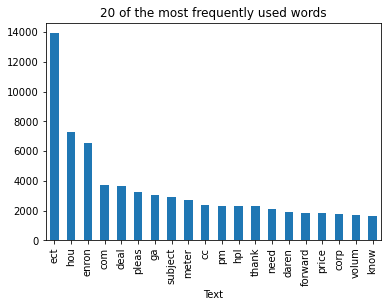

In [124]:
def top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    words = vec.transform(corpus)
    sum_words = words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = top_n_words(emails['text'], 20)
df = pd.DataFrame(words, columns = ['Text' , 'Count'])
df.groupby('Text').sum()['Count'].sort_values(ascending=False).plot(kind='bar', title='20 of the most frequently used words')


## 4. Building the model

#### Vectorizing the text

In [31]:
vectorizer = TfidfVectorizer()
vectorizer.fit(emails["text"])
vector = vectorizer.transform(emails["text"])

In [32]:
y = emails.iloc[:,3]

#### Splitting the data into train/test sets 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(vector,y)

#### Fitting a support vector machine to the training data

In [59]:
model = SVC(C=100,kernel='rbf')
model.fit(X_train,y_train)

0.9845320959010054

## 5. Evaluating the model

In [60]:
# Check accuracy using FP,TP,FN,TN
y_pred = model.predict(X_test)
y_pred = (pd.DataFrame(y_pred)).to_numpy()
y_tes = (pd.DataFrame(y_test)).to_numpy()
TP = FP = TN = FN = 0
for i in range(0,len(y_pred)):
    if(y_pred[i] == 1 and y_tes[i] == 1):
        TP = TP + 1
    elif(y_pred[i] == 1 and y_tes[i] == 0):
        FP = FP + 1
    elif(y_pred[i] == 0 and y_tes[i] == 1):
        FN = FN + 1
    elif(y_pred[i] == 0 and y_tes[i] == 0):
        TN = TN + 1

precision = TP/(TP + FP)
recall =  TP/(TP + FN)
F1 = (2*precision*recall)/(precision+recall)

In [61]:
print("Precision = ",precision)
print("Recall = ",recall)
print("F1 = ",F1)

Precision =  0.9532967032967034
Recall =  0.9914285714285714
F1 =  0.9719887955182074
